# **Classification**

In [ ]:
!nvidia-smi

Wed Oct 26 23:45:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
###############################################################################
### Project: Multi-class Classification
### Model: ResNet50
### ACC:          FLOPs:
###############################################################################

In [2]:
# Importing libraries. 
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision
from torchvision import datasets, transforms, models 
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

#get flops
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
#Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download
from FLOPs_counter import print_model_parm_flops

%matplotlib inline

--2022-10-27 03:29:21--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=97l3itcu0j5bqjohh0crffpvqi; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=Ecu7xbswBzcpf9%2BNmlRSvYQYWxFY7dXRDvqUTHkajgV%2BEKGOIOTUwZu%2BT7Oc3IbosaGn9pYFv6FSb500TmhIynFsaO5K3qZXFW0FwyOE8pmpwo7LqfFczdaJci5UlEn8; expires=Fri, 28-Oct-2022 03:29:22 GMT; Max-Age=86400; path=/plus;; Secure at position 222.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-10-27 03:29:22 (521 MB/s) - ‘download’ saved [5201/5201]



## **1. Loading and Analysing the dataset**

In [3]:
class Data():
    def __init__(self,batch_size):
        self.batch_size = batch_size
        
    def data_augmentation(self,model='Normalization'):
        data_transform = None
        if model=='Normalization': 
            print('Data augmentation: Normalization')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        elif model== 'Normalization + ColorJitter':
            print('Data augmentation: Normalization + ColorJitter')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ColorJitter(brightness=.5, hue=.3),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])
        elif model == 'Normalization + RandomAffine':
            print('Data augmentation: Normalization + RandomAffine')
            data_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        return data_transform


    def loading_data(self,dataset='CIFAR10',model='Normalization'):
        print('Data Information')
        print('='*30)
        print('Batch size:',self.batch_size)
        data_transform = self.data_augmentation(model)
        print('='*30)
        if dataset == 'CIFAR10':
            print('Dataset name: ', dataset)
            # Load data set
            train_set = torchvision.datasets.CIFAR10(root='.\data', download=True, train=True,transform=data_transform)
            test_set = torchvision.datasets.CIFAR10(root='.\data', download=True, train=False,transform=data_transform)
            classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        # Setting seed so that value won't change everytime. 
        torch.manual_seed(10) 
        # Random split training set to training set and validation set
        train_set_size = int(len(train_set) * 0.8)
        valid_set_size = len(train_set) - train_set_size
        train_set, valid_set = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size])

        print('='*30)
        print('Train data set:', len(train_set))
        print('Valid data set:', len(valid_set))
        print('Test data set:', len(test_set))

        # loader
        train_loader = DataLoader(train_set, batch_size=self.batch_size,
                                              shuffle=True, num_workers=2,pin_memory=True)
        val_loader = DataLoader(valid_set, batch_size=self.batch_size,
                                              num_workers=2,pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=self.batch_size,
                                              num_workers=2,pin_memory=True)
        return [train_loader,val_loader,test_loader,classes]
    
    def imshow(self,img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        fig, ax = plt.subplots(figsize=(18,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        
    def preview(self,dataloader):
        # get some random training images
        dataiter = iter(dataloader)
        images, labels = dataiter.next()

        # show images
        self.imshow(torchvision.utils.make_grid(images,nrow=16))
        # print labels
        print(' '.join('%6s' % classes[labels[j]] for j in range(self.batch_size)))
        

Data Information
Batch size: 16
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


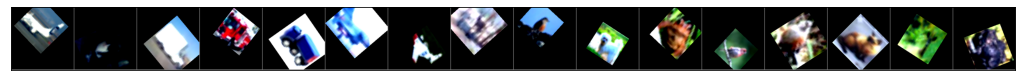

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog


In [ ]:
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model = 'Normalization + RandomAffine')
data.preview(train_loader)

## 2. Device 

In [4]:
 # To check wether Google Colab GPU has been assigned/not. 
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
#device
device = get_default_device()
print(device)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

cuda


## **3. Pretrained Model**

In [5]:
# Convolutional Network - Resnet50 # no trained
class CnnModel_resnet50(nn.Module):
    def __init__(self, n_classes):
        super(CnnModel_resnet50,self).__init__()
        self.num_classes=n_classes
        # Use a pretrained model
        self.network = models.resnet50(pretrained=False)
        # set_parameter_requires_grad(model, feature_extract)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, self.num_classes)
    
    def forward(self, x):
        return self.network(x)

In [6]:
# get parameters
def get_model_parm_nums(model):
  n_parm = sum([param.nelement() for param in model.parameters()])
  print(' + Number of params: %.2f(e6)' % (n_parm / 1e6))
  return n_parm

# Getting flop
def get_flops(model):  
    input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
    #Get the network and its FLOPs
    flops = print_model_parm_flops(model, input, detail=False)
    return flops

In [17]:
# Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
class ClassificationBase():
    def __init__(self, model, n_classes, classes, batch_size, n_epochs, loss_func, opt_func, lr):
        self.model = model
        self.n_classes = n_classes
        self.classes = classes
        self.batch_size = batch_size
        self.epochs = n_epochs
        self.criterion = loss_func
        self.optimizer = opt_func# define optimizer function
        self.lr = lr
        
    def train(self,train_loader):
        optimizer = self.optimizer(self.model.parameters(),self.lr,momentum=0.9)
        correct = 0
        total = 0
        train_losses = []
        for batch, data in enumerate(train_loader,0):
            # get the inputs; data is a list of [inputs,lables]
            inputs, labels = data

            # zero the paramter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)           # Generate predictions
            loss = self.criterion(outputs,labels)  # Calculate loss
            train_losses.append(loss.item())
            # the class with the highest energy is what we choode as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        train_loss = np.sum(train_losses)/len(train_losses)
        train_acc = 100*correct//total
        return train_loss,train_acc
     
    def validation(self,val_loader):
        correct = 0
        total = 0
        val_losses = []
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                outputs = self.model(images)        # Generate predictions
                loss = self.criterion(outputs, labels)  # Calculate loss
                val_losses.append(loss.item())
                # the class with the highest energy is what we choode as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = np.sum(val_losses)/len(val_losses)
        val_acc = 100*correct//total
        return val_loss,val_acc

    def test(self,test_loader):
        # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.classes}
        total_pred = {classname: 0 for classname in self.classes}
        correct = 0
        total = 0
        test_losses = []
        # no gradients needed
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = self.model(images) # Generate predictions
                loss = self.criterion(outputs, labels)  # Calculate loss
                test_losses.append(loss.item())
                _, predictions = torch.max(outputs, 1)
                
                # the class with the highest energy is what we choode as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
                # collect the correct predictions for each class
                for label, prediction in zip(labels,predictions):
                    if label ==  prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1
        
        # print test accuracy and test loss
        test_loss = np.sum(test_losses)/len(test_losses)
        test_acc = 100*correct//total
        print(f'test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}%')
        print('='*40)
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')
        return test_loss,test_acc
                
            
    def fit(self,train_loader, val_loader):
        history = []
        for epoch in range(self.epochs): #loop over the dataset multiple times
            result = dict()
            # Training step
            self.model.train()
            result['train_loss'],result['train_acc'] = self.train(train_loader)
            # Validation step
            self.model.eval()
            result['val_loss'],result['val_acc'] = self.validation(val_loader)
            print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}%, val_loss: {:.4f}, val_acc: {:.4f}%".format(
            epoch+1, result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))
            history.append(result)
        return history
    
    # Visualization
    def plot_accuracies(self,history):
        train_accuracies = [x['train_acc'] for x in history]
        val_accuracies = [x['val_acc'] for x in history]
        plt.plot(train_accuracies, '-bx')
        plt.plot(val_accuracies, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['Training', 'Validation'])
        plt.title('Accuracy vs. No. of epochs')
        plt.show()
    
    def plot_losses(self,history):
        train_losses = [x['train_loss'] for x in history]
        val_losses = [x['val_loss'] for x in history]
        plt.plot(train_losses, '-bx')
        plt.plot(val_losses, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Training', 'Validation'])
        plt.title('Loss vs. No. of epochs')
        plt.show()

## **3. Experiment**

Data Information
Batch size: 16
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .\data/cifar-10-python.tar.gz to .\data
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


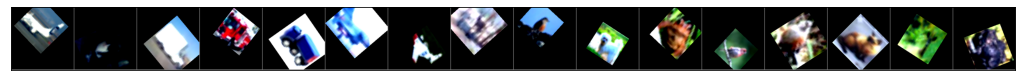

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog
 + Number of params: 23.53(e6)
 + Number of FLOPs: 8.17G
CnnModel_resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

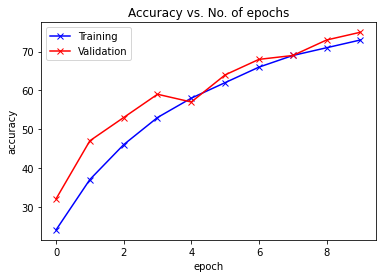

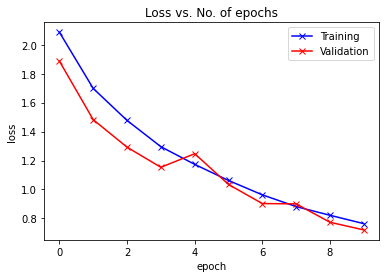

test_loss: 0.7162, test_acc: 75.0000%
Accuracy for class: plane is 82.3%
Accuracy for class: car   is 87.1%
Accuracy for class: bird  is 69.2%
Accuracy for class: cat   is 64.0%
Accuracy for class: deer  is 66.6%
Accuracy for class: dog   is 59.2%
Accuracy for class: frog  is 84.0%
Accuracy for class: horse is 68.8%
Accuracy for class: ship  is 82.3%
Accuracy for class: truck is 86.8%


In [8]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + RandomAffine')
data.preview(train_loader)
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# CNN -- ResNet50-no pretrained
n_classes = 10
print('='*40)
model = CnnModel_resnet50(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 16
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


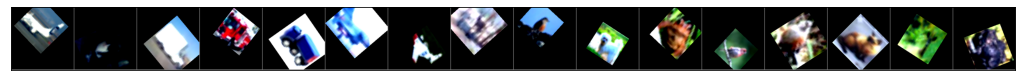

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog
 + Number of params: 23.53(e6)
 + Number of FLOPs: 8.17G
CnnModel_resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

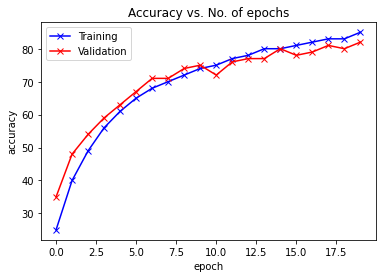

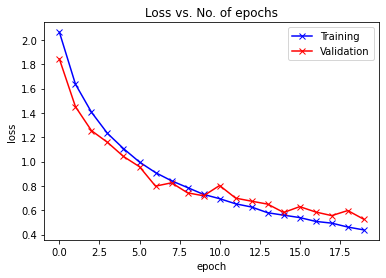

test_loss: 0.5347, test_acc: 82.0000%
Accuracy for class: plane is 85.1%
Accuracy for class: car   is 87.1%
Accuracy for class: bird  is 79.7%
Accuracy for class: cat   is 65.1%
Accuracy for class: deer  is 81.4%
Accuracy for class: dog   is 72.8%
Accuracy for class: frog  is 86.4%
Accuracy for class: horse is 87.1%
Accuracy for class: ship  is 88.9%
Accuracy for class: truck is 87.3%


In [9]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + RandomAffine')
data.preview(train_loader)
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# CNN -- ResNet50-no pretrained
n_classes = 10
print('='*40)
model = CnnModel_resnet50(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 20
lr = 0.001
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

In [26]:
# incorrectly classified
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

model.eval()
# no gradients needed
with torch.no_grad():
    for data,target in test_loader:
        data,target = data.to(device), target.to(device)
        outputs = model(data) # Generate predictions
        pred = outputs.argmax(dim=1,keepdim=True) # pred will be a 2d tensor of shape [batch size, 1]
        idx_mask = ((pred == target.view_as(pred)) == False).view(-1)
        if idx_mask.numel():
          incorrect_examples.append(data[idx_mask].squeeze().cpu().numpy())
          incorrect_labels.append(target[idx_mask].cpu().numpy())
          incorrect_pred.append(pred[idx_mask].squeeze().cpu().numpy())

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
labels: [6]
prediction:4


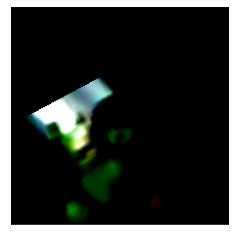

labels: [5 4]
prediction:[4 6]


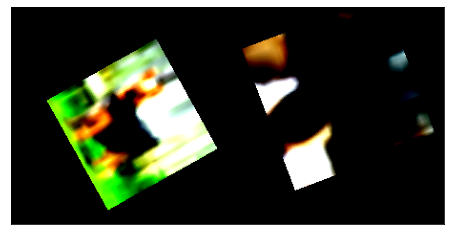

labels: [4 5 2 1 5 9]
prediction:[6 3 3 9 2 7]


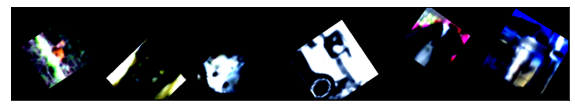

labels: [0 4 6 3 3]
prediction:[7 3 3 5 0]


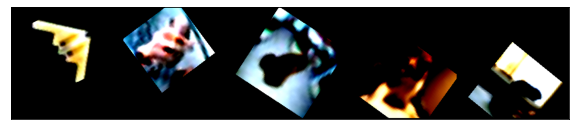

In [31]:
print(classes)
for i in range(4):
    images = torch.from_numpy(incorrect_examples[i])
    print(f'labels: {incorrect_labels[i]}');
    print(f'prediction:{incorrect_pred[i]}');
    fig, ax = plt.subplots(figsize=(10,4));
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=10).permute(1, 2, 0));
    plt.show();

### 3.1 Data Augmentation

Data Information
Batch size: 16
Data augmentation: Normalization + ColorJitter
Dataset name:  CIFAR10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .\data/cifar-10-python.tar.gz to .\data
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

 + Number of params: 23.53(e6)
 + Number of FLOPs: 8.17G
CnnModel_resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

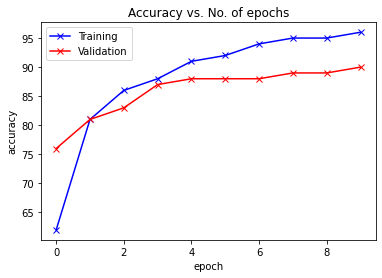

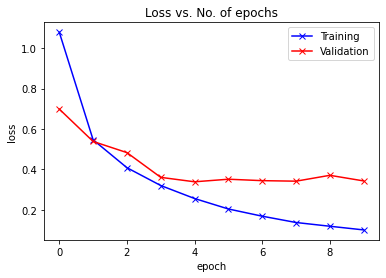

test_loss: 0.3321, test_acc: 90.0000%
Accuracy for class: plane is 93.8%
Accuracy for class: car   is 92.9%
Accuracy for class: bird  is 83.4%
Accuracy for class: cat   is 84.8%
Accuracy for class: deer  is 88.9%
Accuracy for class: dog   is 83.0%
Accuracy for class: frog  is 91.4%
Accuracy for class: horse is 95.2%
Accuracy for class: ship  is 93.0%
Accuracy for class: truck is 95.1%


In [ ]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + ColorJitter')
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
# CNN -- base model
n_classes = 10
print('='*40)
model = CnnModel_resnet50(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.01
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 16
Data augmentation: Normalization + ColorJitter
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

 + Number of params: 23.53(e6)
 + Number of FLOPs: 8.17G
CnnModel_resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

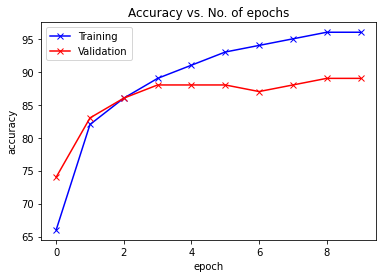

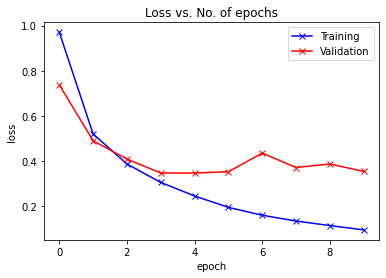

test_loss: 0.3317, test_acc: 89.0000%
Accuracy for class: plane is 91.7%
Accuracy for class: car   is 96.9%
Accuracy for class: bird  is 87.9%
Accuracy for class: cat   is 85.1%
Accuracy for class: deer  is 89.3%
Accuracy for class: dog   is 79.0%
Accuracy for class: frog  is 87.9%
Accuracy for class: horse is 93.6%
Accuracy for class: ship  is 92.3%
Accuracy for class: truck is 94.8%


In [ ]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + ColorJitter')
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
# CNN -- ResNet50
n_classes = 10
print('='*40)
model = CnnModel_resnet50(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.01
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

Data Information
Batch size: 16
Data augmentation: Normalization + RandomAffine
Dataset name:  CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Train data set: 40000
Valid data set: 10000
Test data set: 10000


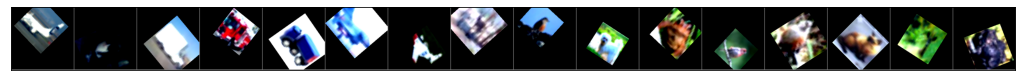

 plane    cat  truck  truck  truck  plane  plane   deer   bird    dog   frog   bird   bird    cat   deer   frog
 + Number of params: 23.53(e6)
 + Number of FLOPs: 8.17G
CnnModel_resnet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

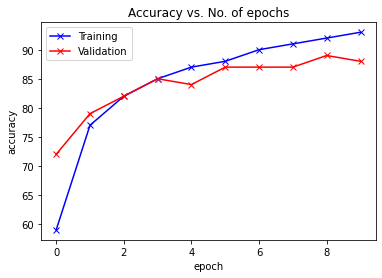

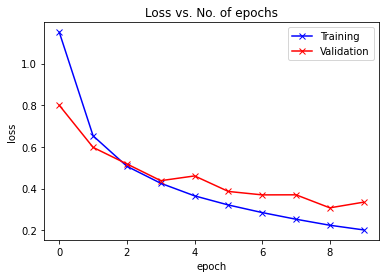

test_loss: 0.3392, test_acc: 88.0000%
Accuracy for class: plane is 90.8%
Accuracy for class: car   is 90.7%
Accuracy for class: bird  is 93.4%
Accuracy for class: cat   is 81.3%
Accuracy for class: deer  is 86.9%
Accuracy for class: dog   is 77.5%
Accuracy for class: frog  is 92.4%
Accuracy for class: horse is 89.6%
Accuracy for class: ship  is 94.3%
Accuracy for class: truck is 90.2%


In [ ]:
# Augmentation
# https://pytorch.org/vision/stable/transforms.html
# data 
batch_size=16
data = Data(batch_size)
train_loader,val_loader,test_loader,classes =\
    data.loading_data(model='Normalization + RandomAffine')
data.preview(train_loader)
#device
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# CNN -- base model
n_classes = 10
print('='*40)
model = CnnModel_resnet50(n_classes)
# model parameters and flops
n_parm = get_model_parm_nums(model)
flops = get_flops(model)
print(to_device(model, device))
print('='*40)
# hyperparameters
n_epochs = 10
lr = 0.01
loss_func = nn.CrossEntropyLoss()
opt_func= torch.optim.SGD
# Train and Evaluate Model
baseline = ClassificationBase(model,n_classes,classes,batch_size,n_epochs,loss_func,opt_func,lr)
history = baseline.fit(train_loader, val_loader)
baseline.plot_accuracies(history)
baseline.plot_losses(history)
print('='*40) 
test = baseline.test(test_loader) 

### learning rate